In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVR
import lightgbm as lgb
from lightgbm import LGBMRegressor
# catboost
from catboost import CatBoostRegressor
# pool
from catboost import Pool
# xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
# remove id
train_data.drop('id', axis=1, inplace=True)
train_data.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


There are no null values in the dataset


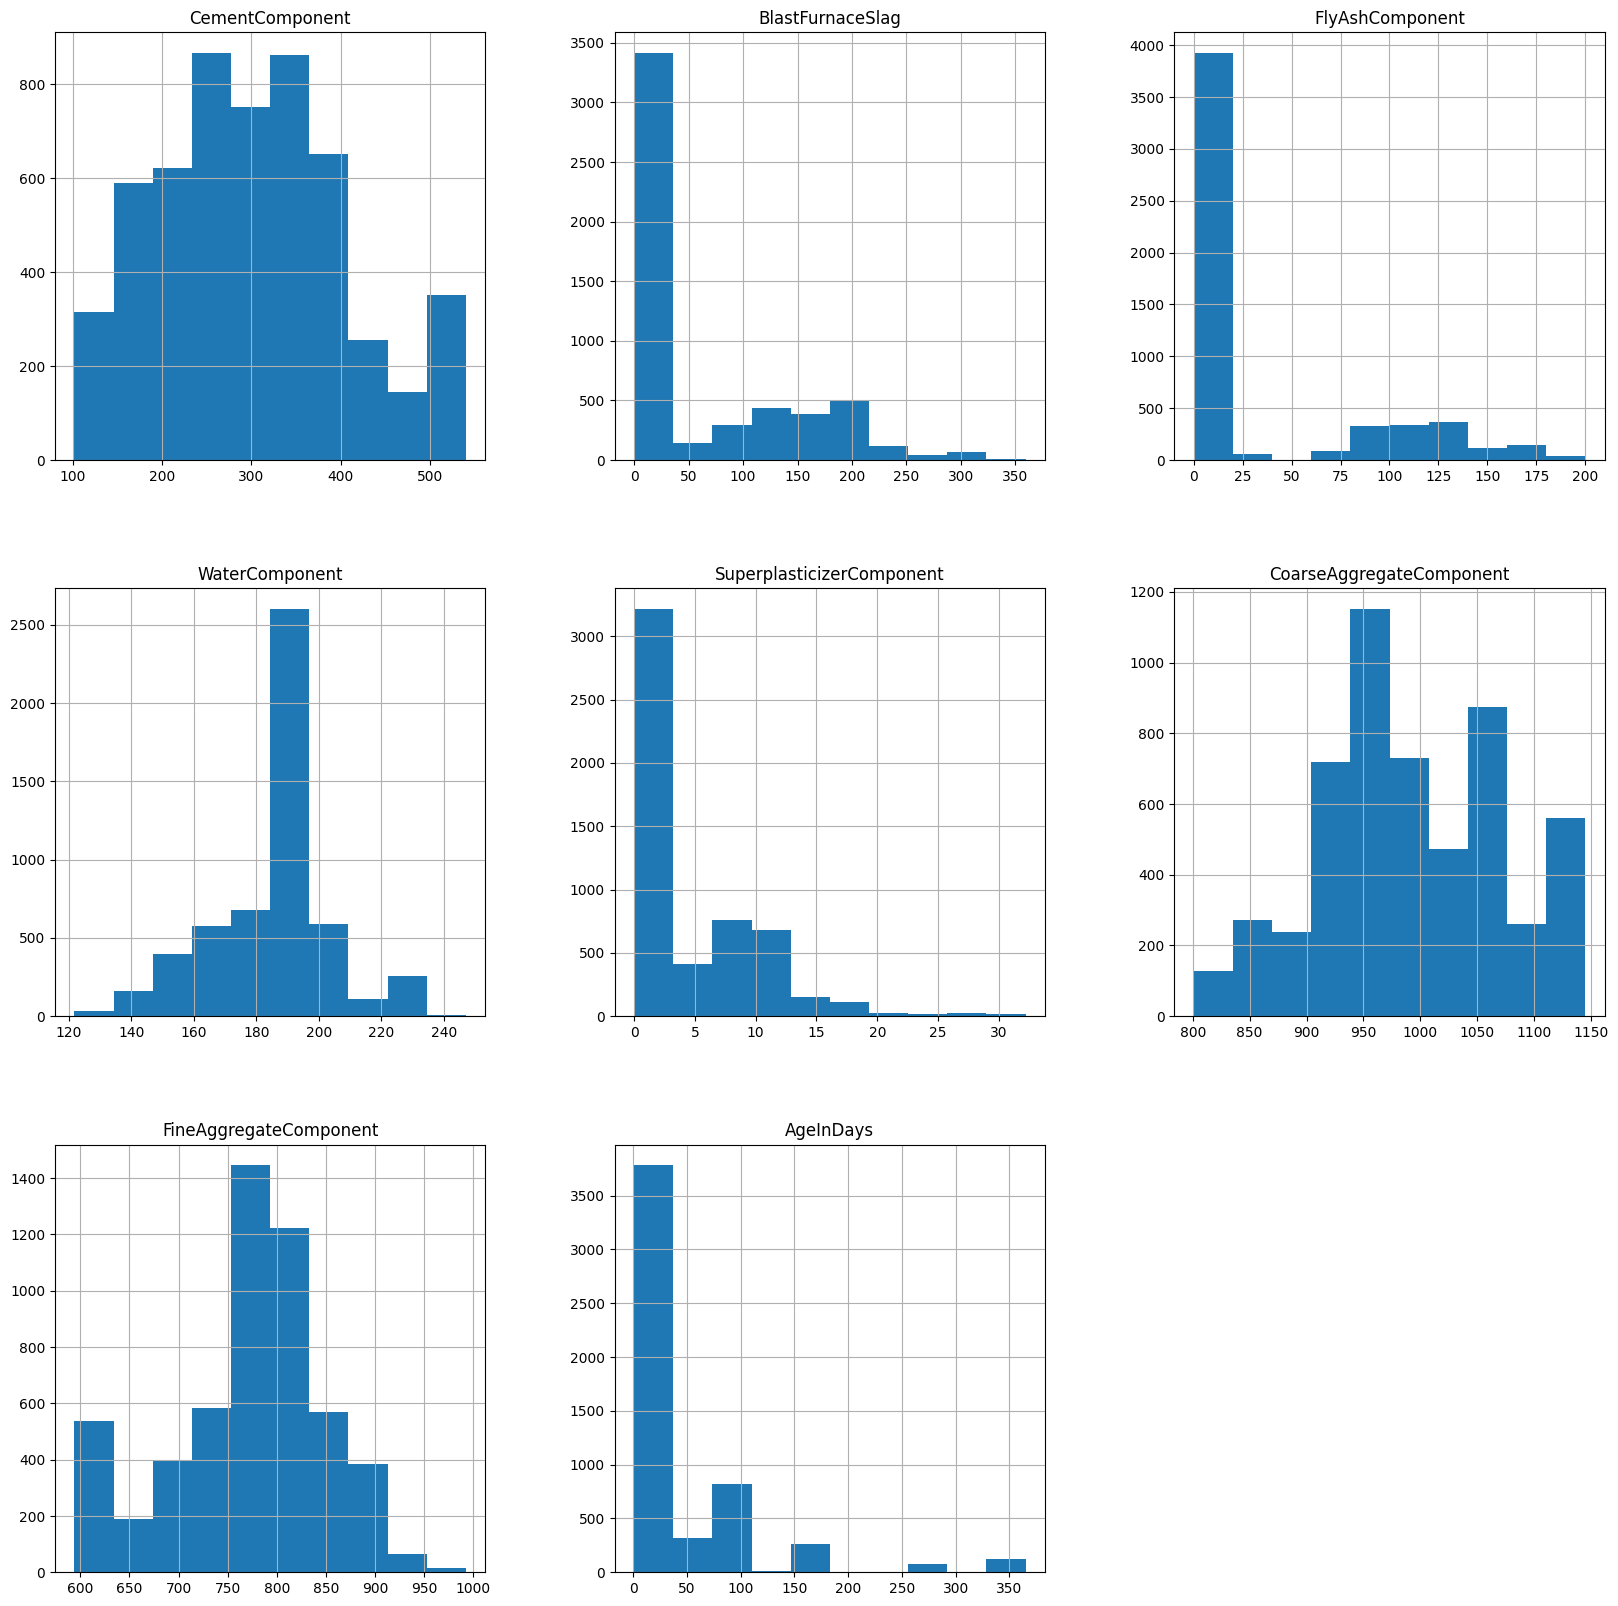

In [5]:
target = 'Strength'
features = train_data.columns.drop([target])
# null values
null_values = train_data.isnull().sum()
if null_values.sum() > 0:
    print("There are null values in the dataset")
else:
    print("There are no null values in the dataset")

# distribution of features
train_data[features].hist(figsize=(20, 20))
plt.show()


In [4]:
# target distribution
# train_data[target].hist()

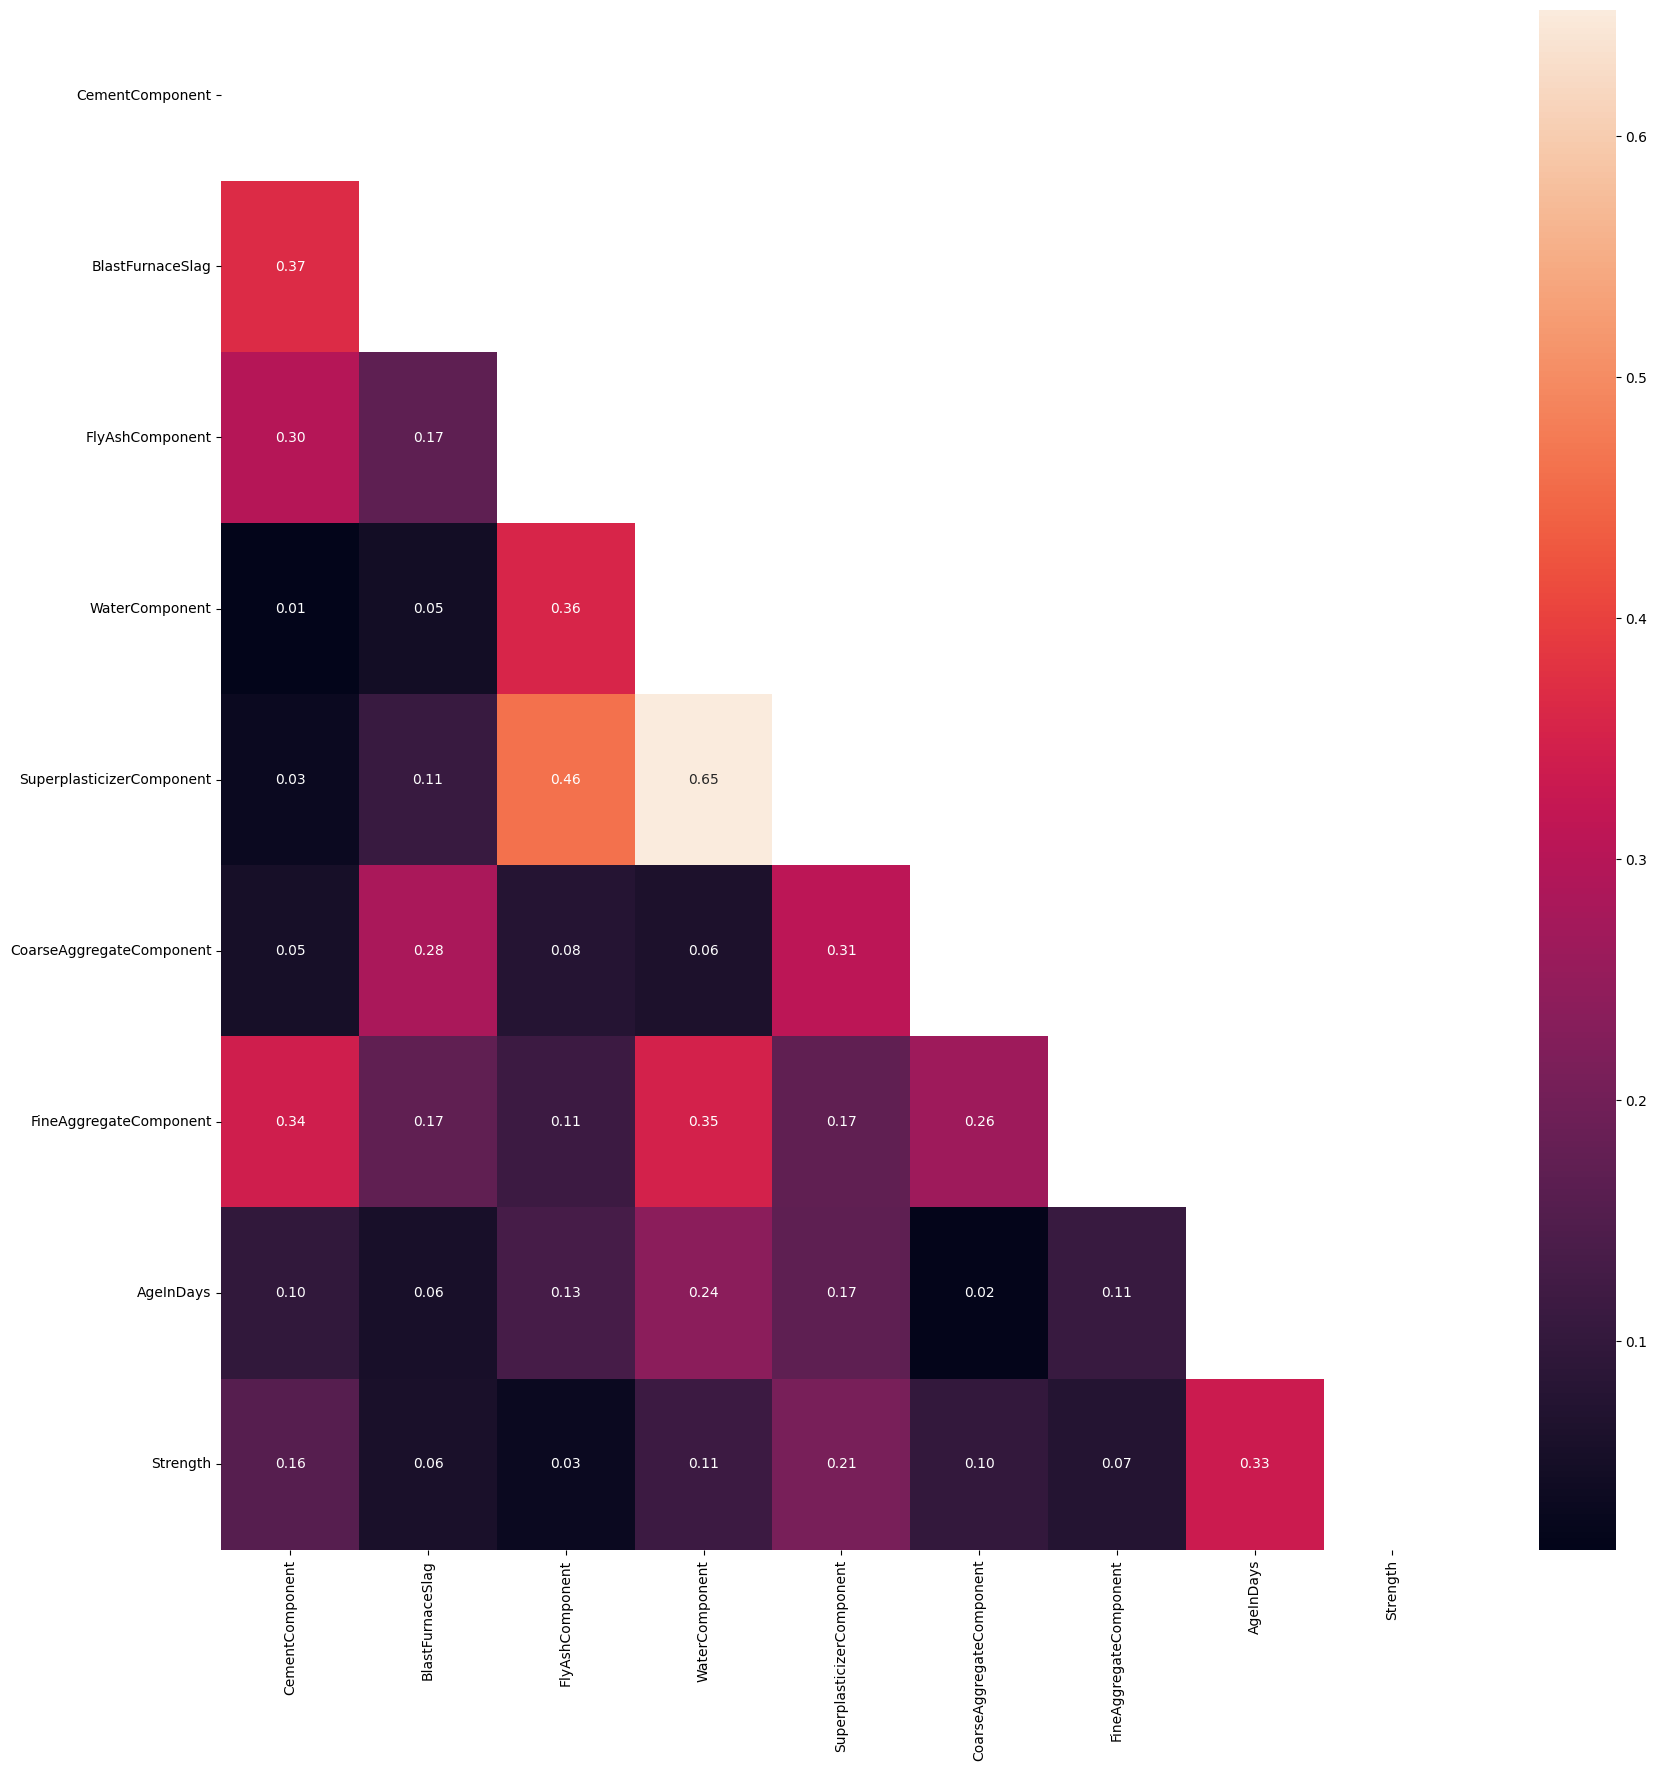

In [6]:
# correlation matrix
corr_matrix = train_data.corr()
# abs
corr_matrix = corr_matrix.abs()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f')
plt.show()

In [16]:
# high correlation features
high_corr_features = corr_matrix[corr_matrix > 0.5].count()
high_corr_features = high_corr_features[high_corr_features > 1].index
high_corr_features

Index(['WaterComponent', 'SuperplasticizerComponent'], dtype='object')

In [4]:
train_data.columns

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'],
      dtype='object')

In [7]:
# feature engineering
def feat_eng(df):
    # Calculate CementToWaterRatio
     # Calculate Water_Cement
    df['Water_Cement'] = df['WaterComponent'] / df['CementComponent']
    
    # Calculate Coarse_Fine
    df['Coarse_Fine'] = df['CoarseAggregateComponent'] / df['FineAggregateComponent']
    
    # Calculate Aggregate
    df['Aggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent']
    
    # Calculate Aggregate_Cement
    df['Aggregate_Cement'] = df['Aggregate'] / df['CementComponent']
    
    # Calculate Slag_Cement
    df['Slag_Cement'] = df['BlastFurnaceSlag'] / df['CementComponent']
    
    # Calculate Ash_Cement
    df['Ash_Cement'] = df['FlyAshComponent'] / df['CementComponent']
    
    # Calculate Plastic_Cement
    df['Plastic_Cement'] = df['SuperplasticizerComponent'] / df['CementComponent']
    
    # Calculate Age_Water
    df['Age_Water'] = df['AgeInDays'] / df['WaterComponent']
    
    return df

train = feat_eng(train_data)
test = feat_eng(test_data)
# adding feature decrease score!

In [8]:
null = train.isnull().sum()
null[null > 0]

Series([], dtype: int64)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(target, axis=1), train[target], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4325, 16), (1082, 16), (4325,), (1082,))

In [25]:
rmse = []
# svr
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X_train):
    svr = SVR(kernel='rbf', C=1e3, gamma=0.1)

    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    svr.fit(X_train_fold, y_train_fold)
    y_pred = svr.predict(X_test_fold)
    rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred)))
print("SVR RMSE: ", np.mean(rmse))

SVR RMSE:  15.0611462685015


In [7]:
rmse = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_test_fold, y_test_fold, reference=lgb_train)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'force_col_wise': True,
        'verbose': 0
    }
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=20,verbose_eval=False)
    y_pred = gbm.predict(X_test_fold, num_iteration=gbm.best_iteration)
    rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred)))

print("LightGBM RMSE: ", np.mean(rmse))

LightGBM RMSE:  12.336968157323929


In [ ]:
def objective(trial):
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'force_col_wise': True,
        'verbose': 0
    }
    rmse = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
        lgb_eval = lgb.Dataset(X_test_fold, y_test_fold, reference=lgb_train)
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=100,
                        valid_sets=lgb_eval,
                        early_stopping_rounds=20,verbose_eval=False)
        y_pred = gbm.predict(X_test_fold, num_iteration=gbm.best_iteration)
        rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred)))
    return np.mean(rmse)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2023-03-12 05:16:19,583] A new study created in memory with name: no-name-48c23324-0efb-4a69-a88e-f68f02768400
[I 2023-03-12 05:16:23,808] Trial 0 finished with value: 12.316743744775989 and parameters: {'n_estimators': 1058, 'num_leaves': 35, 'learning_rate': 0.011598421004324943, 'feature_fraction': 0.5214815017456476, 'bagging_fraction': 0.672800358301056, 'bagging_freq': 2}. Best is trial 0 with value: 12.316743744775989.
[I 2023-03-12 05:16:25,927] Trial 1 finished with value: 12.327390267462317 and parameters: {'n_estimators': 2883, 'num_leaves': 39, 'learning_rate': 0.0307477828231094, 'feature_fraction': 0.7957954354724439, 'bagging_fraction': 0.6639573994605266, 'bagging_freq': 3}. Best is trial 0 with value: 12.316743744775989.
[I 2023-03-12 05:16:28,554] Trial 2 finished with value: 12.327924382492867 and parameters: {'n_estimators': 1280, 'num_leaves': 47, 'learning_rate': 0.024109397845333152, 'feature_fraction': 0.7114431199212065, 'bagging_fraction': 0.552886922631408

In [ ]:
best_params_lgb = {'n_estimators': 2720, 'num_leaves': 5, 'learning_rate': 0.00718907865356397, 'feature_fraction': 0.464839467126649, 'bagging_fraction': 0.4416534495396844, 'bagging_freq': 1}
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(best_params_lgb,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_train,
                early_stopping_rounds=20,verbose_eval=False)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print("LightGBM RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))



LightGBM RMSE:  11.815155558415318


In [ ]:
# catboost
def objective(trial):
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 42,
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 1e3, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-3, 1e3, log=True),
        'border_count': trial.suggest_int('border_count', 2, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 1e3, log=True),
        'od_type': 'Iter',
        'od_wait': 20
    }
    rmse = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        cat_train = Pool(X_train_fold, y_train_fold)
        cat_eval = Pool(X_test_fold, y_test_fold)
        model = CatBoostRegressor(**params)
        model.fit(cat_train, eval_set=cat_eval, verbose=False, early_stopping_rounds=20)
        y_pred = model.predict(X_test_fold)
        rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred)))
    return np.mean(rmse)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)



[I 2023-03-12 05:25:02,310] A new study created in memory with name: no-name-619ddae1-005a-4368-874c-b49a52ff0481
[I 2023-03-12 05:25:34,504] Trial 0 finished with value: 12.22082103271691 and parameters: {'n_estimators': 1061, 'learning_rate': 0.005089022224619027, 'depth': 7, 'l2_leaf_reg': 0.012398233323176673, 'bagging_temperature': 7.187706619021898, 'border_count': 248, 'random_strength': 4.463223909320047}. Best is trial 0 with value: 12.22082103271691.
[I 2023-03-12 05:25:39,678] Trial 1 finished with value: 12.219577390489459 and parameters: {'n_estimators': 1829, 'learning_rate': 0.028353721041926985, 'depth': 4, 'l2_leaf_reg': 47.09451990119067, 'bagging_temperature': 21.771888143944757, 'border_count': 184, 'random_strength': 16.88758647631798}. Best is trial 1 with value: 12.219577390489459.
[I 2023-03-12 05:25:42,561] Trial 2 finished with value: 12.243676594691127 and parameters: {'n_estimators': 2068, 'learning_rate': 0.026629327591994125, 'depth': 6, 'l2_leaf_reg': 0.0

In [9]:
best_params_cat = {
 'learning_rate': 0.08783991648535427,
 'depth': 7,
 'l2_leaf_reg': 24.494730594839957,
 'bagging_temperature': 14.380771221504492,
 'border_count': 178,
 'random_strength': 2.345257036043791,
 'loss_function': 'RMSE',
 'eval_metric': 'RMSE',
 'verbose': 0,
 'random_seed': 42,
 'od_type': 'Iter',
 'od_wait': 20}
 
cat_train = Pool(X_train, y_train)
model = CatBoostRegressor(**best_params_cat)
model.fit(cat_train, verbose=False)

y_pred = model.predict(X_test)
print("CatBoost RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
models.append(model)

CatBoost RMSE:  12.115058173465965


In [ ]:
# xgboost
def objective(trial):
    params = {
        'eval_metric': 'rmse',
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),

        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-3, 1e3, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e3, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }
    rmse = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        dtrain = xgb.DMatrix(X_train_fold, y_train_fold)
        dvalid = xgb.DMatrix(X_test_fold, y_test_fold)
        model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dvalid, 'eval')], early_stopping_rounds=20, verbose_eval=False)
        y_pred = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
        rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred)))
    return np.mean(rmse)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-03-12 05:31:29,272] A new study created in memory with name: no-name-74f69803-02e8-4b2c-b60d-ca9adc4b9a94


[05:31:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:30,965] Trial 0 finished with value: 34.276529953695785 and parameters: {'n_estimators': 2381, 'learning_rate': 0.0014191027486558172, 'max_depth': 2, 'reg_lambda': 9.890818180310387, 'reg_alpha': 29.589709397271537, 'gamma': 0.03996518050579207, 'min_child_weight': 0.0023146216613119087, 'subsample': 0.9291195619000829, 'colsample_bytree': 0.8410792321939329}. Best is trial 0 with value: 34.276529953695785.


[05:31:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:32,238] Trial 1 finished with value: 32.8105689937252 and parameters: {'n_estimators': 2811, 'learning_rate': 0.0021674857271412277, 'max_depth': 4, 'reg_lambda': 54.55102927947573, 'reg_alpha': 0.0027835071481601154, 'gamma': 0.09492556730952256, 'min_child_weight': 89.81416989152714, 'subsample': 0.21431300068884107, 'colsample_bytree': 0.7916454391629004}. Best is trial 1 with value: 32.8105689937252.


[05:31:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:34,317] Trial 2 finished with value: 12.8297963078593 and parameters: {'n_estimators': 1060, 'learning_rate': 0.04640354717908254, 'max_depth': 6, 'reg_lambda': 6.55063433559872, 'reg_alpha': 0.029286195647058547, 'gamma': 2.5335528937095577, 'min_child_weight': 47.26788027047002, 'subsample': 0.7052973751307658, 'colsample_bytree': 0.17131719161967374}. Best is trial 2 with value: 12.8297963078593.


[05:31:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:35,124] Trial 3 finished with value: 34.26892765813055 and parameters: {'n_estimators': 2491, 'learning_rate': 0.001474690953742925, 'max_depth': 7, 'reg_lambda': 1.0920558135645861, 'reg_alpha': 12.694284329433238, 'gamma': 191.61864510527914, 'min_child_weight': 260.69429076281483, 'subsample': 0.4192432933616558, 'colsample_bytree': 0.29874438804653597}. Best is trial 2 with value: 12.8297963078593.


[05:31:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:37,231] Trial 4 finished with value: 12.284045104890446 and parameters: {'n_estimators': 2201, 'learning_rate': 0.06703361223610588, 'max_depth': 5, 'reg_lambda': 25.880628315951526, 'reg_alpha': 0.1898178026656021, 'gamma': 0.4725439777582997, 'min_child_weight': 0.005155438103419102, 'subsample': 0.96739427624752, 'colsample_bytree': 0.2810000181933685}. Best is trial 4 with value: 12.284045104890446.


[05:31:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:39,480] Trial 5 finished with value: 12.471104674375354 and parameters: {'n_estimators': 1247, 'learning_rate': 0.02902254845900879, 'max_depth': 4, 'reg_lambda': 0.20472242599651744, 'reg_alpha': 0.00390112136660042, 'gamma': 0.07328948749783464, 'min_child_weight': 3.832094009430445, 'subsample': 0.8333194398266363, 'colsample_bytree': 0.5255885345043526}. Best is trial 4 with value: 12.284045104890446.


[05:31:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:40,759] Trial 6 finished with value: 32.096107155175766 and parameters: {'n_estimators': 1716, 'learning_rate': 0.002206769696824681, 'max_depth': 2, 'reg_lambda': 1.6055867149572352, 'reg_alpha': 0.0010484170282186892, 'gamma': 11.561162983037823, 'min_child_weight': 15.597649616248903, 'subsample': 0.6151597274450629, 'colsample_bytree': 0.64452105962872}. Best is trial 4 with value: 12.284045104890446.


[05:31:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:42,608] Trial 7 finished with value: 20.367533820665663 and parameters: {'n_estimators': 2974, 'learning_rate': 0.00836999069148637, 'max_depth': 4, 'reg_lambda': 0.0012340676682821119, 'reg_alpha': 96.82094058703669, 'gamma': 149.03421502562313, 'min_child_weight': 37.50373147762366, 'subsample': 0.9789096797275394, 'colsample_bytree': 0.7024984937266839}. Best is trial 4 with value: 12.284045104890446.


[05:31:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:45,738] Trial 8 finished with value: 18.428643843855188 and parameters: {'n_estimators': 1808, 'learning_rate': 0.009831406483931054, 'max_depth': 10, 'reg_lambda': 0.040831300588561485, 'reg_alpha': 0.0018987447970137301, 'gamma': 0.002209519334446443, 'min_child_weight': 151.60558205499152, 'subsample': 0.7527018373915888, 'colsample_bytree': 0.9966952453589984}. Best is trial 4 with value: 12.284045104890446.


[05:31:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:47,553] Trial 9 finished with value: 18.368251993877625 and parameters: {'n_estimators': 2703, 'learning_rate': 0.010953845709354924, 'max_depth': 10, 'reg_lambda': 8.139779983114087, 'reg_alpha': 142.17853675730862, 'gamma': 0.07724348152994098, 'min_child_weight': 2.38931296235602, 'subsample': 0.22470388123321533, 'colsample_bytree': 0.7093502969615431}. Best is trial 4 with value: 12.284045104890446.


[05:31:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:49,818] Trial 10 finished with value: 12.745531022488544 and parameters: {'n_estimators': 2126, 'learning_rate': 0.06238498733233725, 'max_depth': 7, 'reg_lambda': 658.9586333447337, 'reg_alpha': 0.5291024170128065, 'gamma': 10.48223470687588, 'min_child_weight': 0.0600689882504059, 'subsample': 0.505410132748892, 'colsample_bytree': 0.4059332237477401}. Best is trial 4 with value: 12.284045104890446.


[05:31:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:51,539] Trial 11 finished with value: 12.368963373234838 and parameters: {'n_estimators': 1255, 'learning_rate': 0.0996073321721566, 'max_depth': 5, 'reg_lambda': 0.09752512038000091, 'reg_alpha': 0.09329732189550251, 'gamma': 0.47732665793810264, 'min_child_weight': 0.2017396389342268, 'subsample': 0.8481233852585166, 'colsample_bytree': 0.4802422234904019}. Best is trial 4 with value: 12.284045104890446.


[05:31:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:53,725] Trial 12 finished with value: 12.434063388825056 and parameters: {'n_estimators': 1504, 'learning_rate': 0.09800337237684777, 'max_depth': 6, 'reg_lambda': 0.06616849368548007, 'reg_alpha': 0.2569486313316614, 'gamma': 0.734844806262909, 'min_child_weight': 0.052377138671002084, 'subsample': 0.9835671410520437, 'colsample_bytree': 0.40815512838392853}. Best is trial 4 with value: 12.284045104890446.


[05:31:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:55,518] Trial 13 finished with value: 12.97491083326969 and parameters: {'n_estimators': 2207, 'learning_rate': 0.08759257327815369, 'max_depth': 5, 'reg_lambda': 115.53830031070312, 'reg_alpha': 0.06603885866684961, 'gamma': 0.6404548844452612, 'min_child_weight': 0.1449764481185202, 'subsample': 0.8432189276616624, 'colsample_bytree': 0.11718602228353969}. Best is trial 4 with value: 12.284045104890446.


[05:31:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:31:59,204] Trial 14 finished with value: 12.768708453270534 and parameters: {'n_estimators': 1909, 'learning_rate': 0.03547772072862821, 'max_depth': 8, 'reg_lambda': 0.306503164316066, 'reg_alpha': 1.6896229130004934, 'gamma': 0.004158486098724997, 'min_child_weight': 0.0012808570814291035, 'subsample': 0.8322537618799551, 'colsample_bytree': 0.25131260501961605}. Best is trial 4 with value: 12.284045104890446.


[05:31:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:31:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:00,604] Trial 15 finished with value: 12.26256268986182 and parameters: {'n_estimators': 1454, 'learning_rate': 0.09904492279699349, 'max_depth': 3, 'reg_lambda': 0.011147581908871712, 'reg_alpha': 2.387485864496727, 'gamma': 0.655998412247342, 'min_child_weight': 0.014331912181791872, 'subsample': 0.990481362919198, 'colsample_bytree': 0.45379002041742056}. Best is trial 15 with value: 12.26256268986182.


[05:32:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:02,302] Trial 16 finished with value: 12.818411576872771 and parameters: {'n_estimators': 1557, 'learning_rate': 0.026303818797777448, 'max_depth': 3, 'reg_lambda': 0.0068390733661087616, 'reg_alpha': 3.032394418930974, 'gamma': 5.934731068053699, 'min_child_weight': 0.009376222206897485, 'subsample': 0.9963556132844144, 'colsample_bytree': 0.3253771362325844}. Best is trial 15 with value: 12.26256268986182.


[05:32:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:03,753] Trial 17 finished with value: 12.585322909892762 and parameters: {'n_estimators': 2163, 'learning_rate': 0.0551062710777896, 'max_depth': 3, 'reg_lambda': 0.009293180164030712, 'reg_alpha': 690.5471152288022, 'gamma': 45.979007445938784, 'min_child_weight': 0.008688062403412645, 'subsample': 0.7056515383053128, 'colsample_bytree': 0.20414823852737385}. Best is trial 15 with value: 12.26256268986182.


[05:32:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:05,772] Trial 18 finished with value: 13.219426312693543 and parameters: {'n_estimators': 1582, 'learning_rate': 0.022678439725851145, 'max_depth': 3, 'reg_lambda': 0.7065978838389665, 'reg_alpha': 4.06088566161763, 'gamma': 2.19598194952445, 'min_child_weight': 0.010009503077169484, 'subsample': 0.9057219345901645, 'colsample_bytree': 0.37100603382924946}. Best is trial 15 with value: 12.26256268986182.


[05:32:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:08,274] Trial 19 finished with value: 12.335747014413602 and parameters: {'n_estimators': 2510, 'learning_rate': 0.06035835632341513, 'max_depth': 5, 'reg_lambda': 0.001161630434733792, 'reg_alpha': 0.44227185036242955, 'gamma': 0.013992870338979339, 'min_child_weight': 0.0015837134879798243, 'subsample': 0.8996369426335187, 'colsample_bytree': 0.4836937264254781}. Best is trial 15 with value: 12.26256268986182.


[05:32:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:11,690] Trial 20 finished with value: 13.976207103779704 and parameters: {'n_estimators': 2015, 'learning_rate': 0.02018137710768342, 'max_depth': 8, 'reg_lambda': 0.01629074476723403, 'reg_alpha': 1.1738037474582073, 'gamma': 0.2854430391068308, 'min_child_weight': 0.47630088252088015, 'subsample': 0.9984456948477775, 'colsample_bytree': 0.27005334907805784}. Best is trial 15 with value: 12.26256268986182.


[05:32:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:13,427] Trial 21 finished with value: 12.319831356521837 and parameters: {'n_estimators': 2492, 'learning_rate': 0.06552465635533504, 'max_depth': 5, 'reg_lambda': 0.0011804342563870994, 'reg_alpha': 0.33329622622480737, 'gamma': 0.013652556431078988, 'min_child_weight': 0.001040836629485997, 'subsample': 0.8973634555194618, 'colsample_bytree': 0.4625750390399375}. Best is trial 15 with value: 12.26256268986182.


[05:32:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:15,604] Trial 22 finished with value: 12.327615741709755 and parameters: {'n_estimators': 2325, 'learning_rate': 0.06977599984807993, 'max_depth': 5, 'reg_lambda': 0.0031989601126047778, 'reg_alpha': 6.990087783422889, 'gamma': 0.015119822418699073, 'min_child_weight': 0.004799636325629461, 'subsample': 0.7569801131507988, 'colsample_bytree': 0.5589615246881658}. Best is trial 15 with value: 12.26256268986182.


[05:32:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:18,010] Trial 23 finished with value: 12.29929932127724 and parameters: {'n_estimators': 2611, 'learning_rate': 0.04241313797397854, 'max_depth': 4, 'reg_lambda': 0.029907269482487897, 'reg_alpha': 0.20675023624546293, 'gamma': 0.0012235683332779265, 'min_child_weight': 0.02371064756593281, 'subsample': 0.9009178027371966, 'colsample_bytree': 0.3861599745921618}. Best is trial 15 with value: 12.26256268986182.


[05:32:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:19] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:19,950] Trial 24 finished with value: 12.308612549629993 and parameters: {'n_estimators': 2693, 'learning_rate': 0.04322028010155815, 'max_depth': 3, 'reg_lambda': 0.015708232958267555, 'reg_alpha': 0.8692523674277701, 'gamma': 0.0010965740058654285, 'min_child_weight': 0.0240886392053906, 'subsample': 0.9267689053699395, 'colsample_bytree': 0.3258490107156301}. Best is trial 15 with value: 12.26256268986182.


[05:32:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:22,311] Trial 25 finished with value: 12.310139819415134 and parameters: {'n_estimators': 1991, 'learning_rate': 0.039937468296980194, 'max_depth': 4, 'reg_lambda': 0.0494512321517305, 'reg_alpha': 0.12026994598725257, 'gamma': 0.1993126153031148, 'min_child_weight': 0.027356949172571983, 'subsample': 0.7816143636180077, 'colsample_bytree': 0.378171261179947}. Best is trial 15 with value: 12.26256268986182.


[05:32:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:23,402] Trial 26 finished with value: 12.264124104371763 and parameters: {'n_estimators': 1389, 'learning_rate': 0.08440903214401205, 'max_depth': 2, 'reg_lambda': 0.03191652280467765, 'reg_alpha': 0.019715865357629578, 'gamma': 721.2180265253098, 'min_child_weight': 0.004056174709323299, 'subsample': 0.9320277331021805, 'colsample_bytree': 0.23324911553612987}. Best is trial 15 with value: 12.26256268986182.


[05:32:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:24,610] Trial 27 finished with value: 12.914983389037266 and parameters: {'n_estimators': 1408, 'learning_rate': 0.07870758532425591, 'max_depth': 2, 'reg_lambda': 0.005252811921947198, 'reg_alpha': 0.01583264969348546, 'gamma': 949.3065174873171, 'min_child_weight': 0.00695190302675812, 'subsample': 0.9552391593440119, 'colsample_bytree': 0.12167268333772244}. Best is trial 15 with value: 12.26256268986182.


[05:32:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:25,650] Trial 28 finished with value: 12.247260371020536 and parameters: {'n_estimators': 1049, 'learning_rate': 0.09152187649106294, 'max_depth': 2, 'reg_lambda': 0.13302217848631873, 'reg_alpha': 0.009216115462852429, 'gamma': 1.5235599125271684, 'min_child_weight': 0.00360717895952402, 'subsample': 0.8085836092932287, 'colsample_bytree': 0.21988426761435842}. Best is trial 28 with value: 12.247260371020536.


[05:32:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:26,715] Trial 29 finished with value: 12.401334314897769 and parameters: {'n_estimators': 1059, 'learning_rate': 0.05242976527115027, 'max_depth': 2, 'reg_lambda': 0.10222709968629429, 'reg_alpha': 0.00989439629740251, 'gamma': 1.2573048743892552, 'min_child_weight': 0.0022965522900825156, 'subsample': 0.8682756538056051, 'colsample_bytree': 0.19735086668933016}. Best is trial 28 with value: 12.247260371020536.


[05:32:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:27,788] Trial 30 finished with value: 12.24293694964497 and parameters: {'n_estimators': 1234, 'learning_rate': 0.09901662254628754, 'max_depth': 2, 'reg_lambda': 0.017387085270948583, 'reg_alpha': 0.043716204815437094, 'gamma': 31.549690514087217, 'min_child_weight': 0.0020626743030128973, 'subsample': 0.8077845828024182, 'colsample_bytree': 0.23327405994639536}. Best is trial 30 with value: 12.24293694964497.


[05:32:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:29,142] Trial 31 finished with value: 12.23709351564393 and parameters: {'n_estimators': 1246, 'learning_rate': 0.09435651268290343, 'max_depth': 2, 'reg_lambda': 0.019651450704580797, 'reg_alpha': 0.038849289896094104, 'gamma': 25.536196687909836, 'min_child_weight': 0.0027286730105281266, 'subsample': 0.7966589205659584, 'colsample_bytree': 0.22768178269060105}. Best is trial 31 with value: 12.23709351564393.


[05:32:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:30,093] Trial 32 finished with value: 12.32277535986266 and parameters: {'n_estimators': 1208, 'learning_rate': 0.09367649152563738, 'max_depth': 2, 'reg_lambda': 0.014584200958917201, 'reg_alpha': 0.005905918768034288, 'gamma': 26.647425751834405, 'min_child_weight': 0.002687388318762148, 'subsample': 0.6801086310517908, 'colsample_bytree': 0.1591195908325434}. Best is trial 31 with value: 12.23709351564393.


[05:32:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:31,594] Trial 33 finished with value: 12.254551948787753 and parameters: {'n_estimators': 1005, 'learning_rate': 0.09896307724745257, 'max_depth': 3, 'reg_lambda': 0.0033696507789494775, 'reg_alpha': 0.0734697272338925, 'gamma': 3.7970379395027245, 'min_child_weight': 0.0010687221138158292, 'subsample': 0.7712758701624856, 'colsample_bytree': 0.2259266737628022}. Best is trial 31 with value: 12.23709351564393.


[05:32:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:32,739] Trial 34 finished with value: 12.734846125021033 and parameters: {'n_estimators': 1138, 'learning_rate': 0.051847238066114146, 'max_depth': 2, 'reg_lambda': 0.002509121325542823, 'reg_alpha': 0.039783328676519354, 'gamma': 3.2203351199591546, 'min_child_weight': 0.0010003325168846762, 'subsample': 0.786851879033535, 'colsample_bytree': 0.18173425836674661}. Best is trial 31 with value: 12.23709351564393.


[05:32:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:34,596] Trial 35 finished with value: 12.265947865096853 and parameters: {'n_estimators': 1117, 'learning_rate': 0.07200657475953685, 'max_depth': 3, 'reg_lambda': 0.0047693094841124595, 'reg_alpha': 0.04024911305628081, 'gamma': 4.552321414421743, 'min_child_weight': 0.003107396987737223, 'subsample': 0.6658473597509704, 'colsample_bytree': 0.23416739800884998}. Best is trial 31 with value: 12.23709351564393.


[05:32:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:36,703] Trial 36 finished with value: 12.986319483175341 and parameters: {'n_estimators': 1024, 'learning_rate': 0.07508248110380403, 'max_depth': 2, 'reg_lambda': 0.1523378305068576, 'reg_alpha': 0.006876818110459718, 'gamma': 1.6518399187084878, 'min_child_weight': 0.002187586494860567, 'subsample': 0.8029813735304656, 'colsample_bytree': 0.10358029569880958}. Best is trial 31 with value: 12.23709351564393.


[05:32:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:36] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:37,950] Trial 37 finished with value: 12.288688942569578 and parameters: {'n_estimators': 1310, 'learning_rate': 0.05131739262404847, 'max_depth': 3, 'reg_lambda': 0.0025485965447743847, 'reg_alpha': 0.01449939333727671, 'gamma': 23.886565237116614, 'min_child_weight': 0.0041186015490716444, 'subsample': 0.7285009244403264, 'colsample_bytree': 0.29271668082380853}. Best is trial 31 with value: 12.23709351564393.


[05:32:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:39,037] Trial 38 finished with value: 13.45431327743491 and parameters: {'n_estimators': 1327, 'learning_rate': 0.03153363345932586, 'max_depth': 2, 'reg_lambda': 0.025924638649535876, 'reg_alpha': 0.03533106680840717, 'gamma': 7.508036475092596, 'min_child_weight': 0.0024413896981716333, 'subsample': 0.6358212810114594, 'colsample_bytree': 0.14868583442025013}. Best is trial 31 with value: 12.23709351564393.


[05:32:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:39] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:40,614] Trial 39 finished with value: 12.318858353669755 and parameters: {'n_estimators': 1161, 'learning_rate': 0.0741386842954596, 'max_depth': 4, 'reg_lambda': 0.06115878930756416, 'reg_alpha': 0.0038672900637173216, 'gamma': 2.8602035873627965, 'min_child_weight': 0.005645753749841321, 'subsample': 0.8014099973309134, 'colsample_bytree': 0.21308285722996648}. Best is trial 31 with value: 12.23709351564393.


[05:32:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:42,059] Trial 40 finished with value: 12.284462163969101 and parameters: {'n_estimators': 1628, 'learning_rate': 0.049123017448102255, 'max_depth': 3, 'reg_lambda': 0.007961380095556898, 'reg_alpha': 0.07157256852996312, 'gamma': 91.43995387198713, 'min_child_weight': 0.0011852156152283644, 'subsample': 0.7365939918446676, 'colsample_bytree': 0.31594918122844734}. Best is trial 31 with value: 12.23709351564393.


[05:32:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:43,397] Trial 41 finished with value: 12.246850862175487 and parameters: {'n_estimators': 1002, 'learning_rate': 0.09346566200500836, 'max_depth': 3, 'reg_lambda': 0.011711106649549038, 'reg_alpha': 0.026617376785865808, 'gamma': 1.2141540504828054, 'min_child_weight': 0.008942158827567827, 'subsample': 0.8574799531844017, 'colsample_bytree': 0.24522555014955003}. Best is trial 31 with value: 12.23709351564393.


[05:32:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:43] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:44,407] Trial 42 finished with value: 12.4044208606751 and parameters: {'n_estimators': 1005, 'learning_rate': 0.07787822650201152, 'max_depth': 2, 'reg_lambda': 0.02203579026134282, 'reg_alpha': 0.024459068603447136, 'gamma': 14.615748740157237, 'min_child_weight': 0.012597993269160675, 'subsample': 0.7706120765441363, 'colsample_bytree': 0.17663440567346544}. Best is trial 31 with value: 12.23709351564393.


[05:32:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:45,146] Trial 43 finished with value: 12.322550293072425 and parameters: {'n_estimators': 1207, 'learning_rate': 0.062161009345177196, 'max_depth': 2, 'reg_lambda': 0.01187081924189101, 'reg_alpha': 0.008444618769305325, 'gamma': 5.503159028672177, 'min_child_weight': 0.0023312464943132994, 'subsample': 0.8556311924001371, 'colsample_bytree': 0.24234285497128072}. Best is trial 31 with value: 12.23709351564393.


[05:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:46,023] Trial 44 finished with value: 12.292879732716951 and parameters: {'n_estimators': 1097, 'learning_rate': 0.0946720996749482, 'max_depth': 4, 'reg_lambda': 0.047348909333375114, 'reg_alpha': 0.0027709564863251227, 'gamma': 1.8331472479620252, 'min_child_weight': 0.005150464664538746, 'subsample': 0.8158650225176722, 'colsample_bytree': 0.28021877946975904}. Best is trial 31 with value: 12.23709351564393.


[05:32:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:47,131] Trial 45 finished with value: 12.52533142615742 and parameters: {'n_estimators': 1352, 'learning_rate': 0.06270468897247938, 'max_depth': 3, 'reg_lambda': 0.004008010538449404, 'reg_alpha': 0.13273080665110007, 'gamma': 12.691046161019807, 'min_child_weight': 0.001017993861930505, 'subsample': 0.7246512024174754, 'colsample_bytree': 0.14512221051830063}. Best is trial 31 with value: 12.23709351564393.


[05:32:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:48,623] Trial 46 finished with value: 12.2323946313819 and parameters: {'n_estimators': 1231, 'learning_rate': 0.09869684284221653, 'max_depth': 3, 'reg_lambda': 0.2943401665838881, 'reg_alpha': 0.059392575315226036, 'gamma': 3.7168558669686527, 'min_child_weight': 0.003500755924922891, 'subsample': 0.8622450328783035, 'colsample_bytree': 0.20342321514930917}. Best is trial 46 with value: 12.2323946313819.


[05:32:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:49,777] Trial 47 finished with value: 12.237125437863977 and parameters: {'n_estimators': 1683, 'learning_rate': 0.07884357841426627, 'max_depth': 2, 'reg_lambda': 0.21777699987675292, 'reg_alpha': 0.013135355072934712, 'gamma': 50.81464605439639, 'min_child_weight': 0.01873180871479178, 'subsample': 0.8711433047231756, 'colsample_bytree': 0.2720112992316028}. Best is trial 46 with value: 12.2323946313819.


[05:32:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:52,034] Trial 48 finished with value: 12.604349126323578 and parameters: {'n_estimators': 1642, 'learning_rate': 0.03506909613229464, 'max_depth': 6, 'reg_lambda': 0.25037280234431303, 'reg_alpha': 0.04134163162908742, 'gamma': 58.039824582488166, 'min_child_weight': 0.016499542078410867, 'subsample': 0.8558255901616296, 'colsample_bytree': 0.27091428011317886}. Best is trial 46 with value: 12.2323946313819.


[05:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-03-12 05:32:55,948] Trial 49 finished with value: 12.734200209447767 and parameters: {'n_estimators': 1733, 'learning_rate': 0.07729739871006663, 'max_depth': 9, 'reg_lambda': 0.43156649457971663, 'reg_alpha': 0.14822478531424885, 'gamma': 22.872946852313664, 'min_child_weight': 0.05490664955284295, 'subsample': 0.9466730168598384, 'colsample_bytree': 0.34487614033364344}. Best is trial 46 with value: 12.2323946313819.


In [10]:
best_params_xgb = {'learning_rate': 0.0751296664625052,
 'max_depth': 3,
 'reg_lambda': 18.073247177060047,
 'reg_alpha': 19.61698834021871,
 'gamma': 11.05598628385335,
 'min_child_weight': 0.0018190717370103705,
 'subsample': 0.5094133634758418,
 'colsample_bytree': 0.5038756700023512,
 'eval_metric': 'rmse',
 'objective': 'reg:squarederror',
 'booster': 'gbtree',
 'random_state': 42}

dtrain = xgb.DMatrix(X_train, y_train)
model = xgb.train(best_params_xgb, dtrain, num_boost_round=100, evals=[(dtrain, 'train')], early_stopping_rounds=20, verbose_eval=False)
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)
print("XGBoost RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
models.append(model)

XGBoost RMSE:  11.829934534891866


In [16]:
# stacking
from sklearn.ensemble import StackingRegressor

lgb = LGBMRegressor(**best_params_lgb)
cat = CatBoostRegressor(**best_params_cat)
xgb = XGBRegressor(**best_params_xgb)
estimators = [('lgb', lgb), ('cat', cat), ('xgb', xgb)]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
print("Stacking RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

[LightGBM] [Warning] feature_fraction is set=0.9487804729083106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9487804729083106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8072784247840686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8072784247840686
[LightGBM] [Warning] feature_fraction is set=0.9487804729083106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9487804729083106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8072784247840686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8072784247840686
[LightGBM] [Warning] feature_fraction is set=0.9487804729083106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9487804729083106
[LightGBM] [Warning] bagging

In [15]:
# blending
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split

# split the training data into two parts
x_train1, x_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# train the level 1 models on the first part
lgb = LGBMRegressor(**best_params_lgb)
cat = CatBoostRegressor(**best_params_cat)
xgb = XGBRegressor(**best_params_xgb)
estimators = [('lgb', lgb), ('cat', cat), ('xgb', xgb)]
for name, model in estimators:
  model.fit(x_train1, y_train1)

# use the predictions of the level 1 models on the second part as the input for the meta-model
x_meta = np.column_stack([model.predict(x_train2) for name, model in estimators])
meta_model = LinearRegression()
meta_model.fit(x_meta, y_train2)

# use the meta-model to make predictions on the test data
x_test_meta = np.column_stack([model.predict(X_test) for name, model in estimators])
y_pred = meta_model.predict(x_test_meta)
print("blending rmse: ", np.sqrt(mean_squared_error(y_test, y_pred)))

def predict(test):
  # write above in function
  # predict the test data
  x_test_meta = np.column_stack([model.predict(test) for name, model in estimators])
  y_pred = meta_model.predict(x_test_meta)
  return y_pred

[LightGBM] [Warning] feature_fraction is set=0.9487804729083106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9487804729083106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8072784247840686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8072784247840686
[LightGBM] [Warning] feature_fraction is set=0.9487804729083106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9487804729083106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8072784247840686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8072784247840686
blending rmse:  11.85475769587459


In [16]:
competition_name = 'playground-series-s3e9'
test_X = test.drop('id', axis=1)
y_pred = predict(test_X)
submission = pd.DataFrame({'id': test['id'], 'Strength': y_pred})
submission.to_csv(f'{competition_name}.csv', index=False)
message = 'lgb'
!kaggle competitions submit -c {competition_name} -f {competition_name}.csv -m "{message}"

100%|██████████████████████████████████████| 82.0k/82.0k [00:01<00:00, 82.8kB/s]
Successfully submitted to Playground Series - Season 3, Episode 9